# TP 3 Entrainement d'un agent avec une Q-table

Nous allons créer agent d'apprentissage par renforcement qui apprend à jouer au jeu du pendu en utilisant la méthode Q-learning.

In [1]:
import numpy as np
from My_custom_Envs import HangedManEnv
import statsmodels
import random


### 1. **Créer la policie : la fonction epsilon_greedy_policy**

Un greedy algorithm (algorithme glouton) est un algorithme de décision qui choisit l’action qui semble maximiser le gain immédiat à chaque étape, sans se soucier des conséquences futures. 

Pour l'apprentissage nous avons besoin d'__explorer__ c'est à dire de trouver les probablitées pour toutes les Q-tables

In [2]:
def epsilon_greedy_policy(state,q_table,epsilon= 0.3):
    """
    Returns an action based on epsilon-greedy policy.
    """
    if np.random.uniform(0, 1) < epsilon:
        # Exploration : Choisi une action aléatoire parmi les actionns possibl
        active_actions = np.where((1 - state[1]))[0]
        return random.choice(active_actions)
    else:
        
        # Exploitation: Choisir l'action avec la Q-value maximale pour l'état courant
        # Selection la ligne qui corresponds à l'état courant
        masked_q_values = np.copy(q_table[state[0]])    
        
        # Masque les actions interdites en utilisant le second éléments de l'entrée ( les lettres déjà jouées) , si il y a des actions interdites. 
        if sum( state[1] ) > 0 : masked_q_values[state[1]] = -np.inf  
       
        # renvoi l'action qui corresponds à la Q-value maximale 
        return np.argmax(masked_q_values)  

### 2. **Initialiser les paramètres et les variables de stockage**

In [3]:
max_length = 5
## Les mesures que l'on va garder par épisode 
n_episode = 50000

### 3 & 4  Commençons l'apprentissage 

In [4]:
hist_reward = np.zeros(n_episode)         # les rewards obtenu par épisodes 
hist_actions = np.zeros((26, n_episode))  # l'ordre les lettres choisies ( dictionnaire de liste)

# Parameters influencing learning performance 
init_value_qtable = 0
epsilon = 0.3
learning_rate = .1
# Initialisation de la Q-table
q_table = np.full(( 28**max_length, 26), init_value_qtable, dtype=float)  # 32 états possibles et 26 actions (lettres)
                        # max_length correspond HangedManEnv.max_word_size , by default 8 
env = HangedManEnv(max_word_size=max_length)
# Initialisation de l'environnement

for episode in range(n_episode):
    
    # Restart episode
    obs, info = env.reset()
    terminated = False
    step = 1
    ## Convert observation to state  for indexing in Q-table
    state_index = np.dot(obs[0], [28**i for i in range(max_length)])

    while not terminated: 
            
        #### Choisi l'action
        action = epsilon_greedy_policy( state=( state_index, obs[1]), epsilon=epsilon, q_table=q_table)   # obs[1] : contient les lettres restantes à jouer
        
        #### Jouer l'action choisie
        obs , reward, terminated, _, _  =env.step( action )  

        #### Mise à jour de la Q_table

        # Convertir le state en index 
        next_state_index = np.dot(obs[0], [28**i for i in range(max_length)])

        best_next_action = np.argmax(q_table[next_state_index])
        td_target = reward + q_table[next_state_index][best_next_action]
        td_error = td_target - q_table[state_index][action]
        q_table[state_index][action] += learning_rate * td_error

        state_index = next_state_index
        

        ##  Sauve des données d'entrainement pour analyser
        hist_actions[ action, episode ] = step
        hist_reward[episode] = hist_reward[episode] + reward
        step = step + 1 

env.close()

### Affichage

In [5]:
window_size = 500
moving_avg_rewards = np.convolve(hist_reward, np.ones(window_size)/window_size, mode='valid')


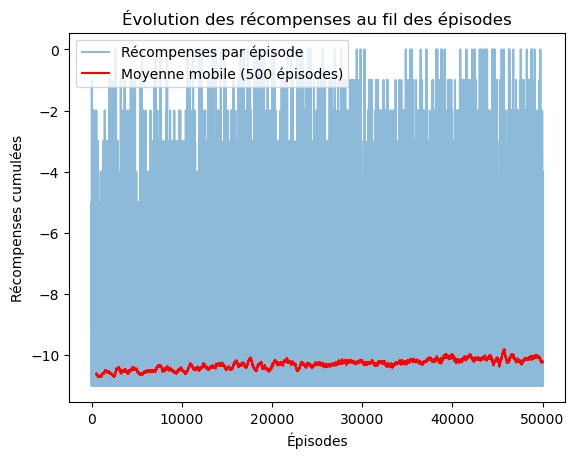

In [6]:
import matplotlib.pyplot as plt
# Tracer l'évolution des récompenses par épisode
plt.plot(range(n_episode), hist_reward, label='Récompenses par épisode', alpha=0.5)
plt.plot(range(window_size-1, n_episode), moving_avg_rewards, label=f'Moyenne mobile ({window_size} épisodes)', color='red')
# Ajouter un titre et des labels
plt.title("Évolution des récompenses au fil des épisodes")
plt.xlabel("Épisodes")
plt.ylabel("Récompenses cumulées")

# Afficher la légende et le graphique
plt.legend()
plt.show()

In [7]:
n_victories = sum(hist_reward > -11 )
# Calcul de la probabilité de gagner
probability_of_winning = n_victories / n_episode
print(f"Probabilité de gagner après {n_episode} parties : {probability_of_winning:.2f}")


from statsmodels.stats.proportion import proportion_confint
confidence_level = 0.95  # Intervalle de confiance à 95%


# Calculer l'intervalle de confiance avec l'approximation normale (méthode 'normal')
lower_bound, upper_bound = proportion_confint(n_victories, n_episode, alpha=1-confidence_level, method='normal')

print(f"Proportion observée : {probability_of_winning:.4f}")
print(f"Intervalle de confiance à 95% : [{lower_bound:.4f}, {upper_bound:.4f}]")

Probabilité de gagner après 50000 parties : 0.18
Proportion observée : 0.1799
Intervalle de confiance à 95% : [0.1765, 0.1833]



​
